# Data Analysis

Flight delay has a great influence on other industries such as tourism, insurance, etc. Plenty of factors could determine the flight delay. BTS (Bureau of Transportation Statistics) categories these factors as Air Carrier, Extreme Weather, National Aviation System (NAS), Late-arriving aircraft and Security, and record the delay time caused by them.

We collect the flight data from 2021-01-01 to 2021-12-31 and the weather data of origin cities and destination cities and store them in a sqlite3 database (see more details in `data_collection.ipynb`).

## Descriptive Statistics

Descriptive statistics are brief descriptive coefficients that summarize a given data set. 

In [2]:
import sqlite3
import pandas as pd
import json
from matplotlib import pyplot as plt
import math

pd.set_option('max_colwidth',200)   # max display length of vale
pd.set_option('display.max_columns',None)   # max display columns
pd.set_option('display.max_rows',None)  # max display rows
pd.set_option('display.float_format',lambda x: '%.3f'%x) # nonuse scientific notation to show value

%matplotlib inline

# import the config setting
with open('config.json','r+',encoding='utf-8') as f:
    config=json.load(f)

# connect the database
db=sqlite3.connect(config['Database'])
print('[INFO]: connect database successfully')

# create a cursor object to operate the db
cur=db.cursor()

[INFO]: connect database successfully


The whole flight table includes over 6 million data which could make the analyzing procedure slowly. Therefore, we sample 100,000 data randomly and analyze them, the analyzing result could be similar with using all the data cause law of large numbers.

In [3]:
# load the data from database to memory
sql='''SELECT 
        QUARTER,
        MONTH,
        DAY_OF_MONTH,
        DAY_OF_WEEK,
        MKT_UNIQUE_CARRIER,
        MKT_CARRIER_FL_NUM,
        AIR_TIME,
        DISTANCE,
        ARR_DELAY,
        ARR_DELAY_NEW,
        CARRIER_DELAY,
        WEATHER_DELAY,
        NAS_DELAY,
        SECURITY_DELAY,
        LATE_AIRCRAFT_DELAY 
                FROM flight
        ORDER BY RANDOM()
        LIMIT 100000;'''
        
df_delay=pd.read_sql(sql,db)    # read sql table
df_delay.head() # print the head of the df

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,AIR_TIME,DISTANCE,ARR_DELAY,ARR_DELAY_NEW,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,3,7,28,3,AA,5340,21.000,91.000,-20.000,0.000,NaN,NaN,NaN,NaN,NaN
1,2,6,1,2,WN,2184,236.000,1838.000,-3.000,0.000,NaN,NaN,NaN,NaN,NaN
2,2,4,9,5,B6,131,308.000,2218.000,-9.000,0.000,NaN,NaN,NaN,NaN,NaN
3,1,1,1,5,WN,2585,88.000,519.000,-13.000,0.000,NaN,NaN,NaN,NaN,NaN
4,4,10,31,7,UA,3497,39.000,182.000,-4.000,0.000,NaN,NaN,NaN,NaN,NaN


I replace `NaN` in the table by 0 in the data cleaning procedure.

In [4]:
# NaN in this table means 0, replace NaN by 0
df_delay=df_delay.fillna(0)
df_delay.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,AIR_TIME,DISTANCE,ARR_DELAY,ARR_DELAY_NEW,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,3,7,28,3,AA,5340,21.000,91.000,-20.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2,6,1,2,WN,2184,236.000,1838.000,-3.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2,4,9,5,B6,131,308.000,2218.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,1,1,5,WN,2585,88.000,519.000,-13.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4,10,31,7,UA,3497,39.000,182.000,-4.000,0.000,0.000,0.000,0.000,0.000,0.000


From the description of the table, we could find that the number of flights arriving in advance is more than those are delay, and over 75% flights are delay less than 15 minutes. For the delay time by various factors, over 75% flights' delay time is 0. There is a great imbalance in the delay time, which could make a trouble in analysis. 

In [5]:
# print the descriptive of the data
df_delay.describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_FL_NUM,AIR_TIME,DISTANCE,ARR_DELAY,ARR_DELAY_NEW,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,2.650,6.966,15.823,4.015,2791.838,108.276,795.026,3.303,12.376,4.652,0.807,1.857,0.030,4.085
std,1.080,3.308,8.796,2.010,1826.117,69.793,582.581,50.700,47.438,33.841,15.467,11.214,1.409,24.575
min,1.000,1.000,1.000,1.000,1.000,0.000,31.000,-85.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,4.000,8.000,2.000,1192.000,58.000,370.000,-16.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,3.000,7.000,16.000,4.000,2444.000,92.000,646.000,-7.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,4.000,10.000,23.000,6.000,4429.000,139.000,1032.000,5.000,5.000,0.000,0.000,0.000,0.000,0.000
max,4.000,12.000,31.000,7.000,9648.000,653.000,5095.000,3089.000,3089.000,3089.000,1449.000,591.000,264.000,1511.000


Then I compute the sum of these delay time and make a pie chart show them. The following results show that the sum of delay time caused by the above causes is less than the sum of total delay time though they are very similar. So there exist some other factors which are not recorded by BTS.

Besides, carrier cost most delay time and late aircraft is second. However, late aircraft could be reasoned by other factors, it is not a fundamental cause for delay. NAS make a strong influence and weather delay time is about 7%, security is the least influential factor.

total of arrive delay time:1222510.0 min
the sum of delay time caused by the 5 causes1126617.0 min
CARRIER_DELAY         458665.000
WEATHER_DELAY          70722.000
NAS_DELAY             187350.000
SECURITY_DELAY          3683.000
LATE_AIRCRAFT_DELAY   406197.000
dtype: object


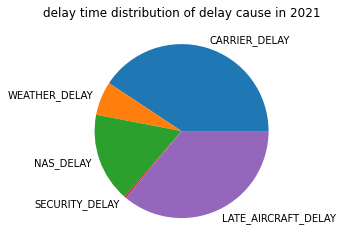

In [6]:
# compute sum of each column
df_sum=df_delay.sum(0)

# print the total delay time and the sum of delay time for each cause
print(f"total of arrive delay time:{df_sum['ARR_DELAY_NEW']} min")
print(f"the sum of delay time caused by the 5 causes{df_sum[config['Delay Cause']].sum()} min")
# plot pie charts of delay time
df_sum[config['Delay Cause']].plot.pie(title='delay time distribution of delay cause in 2021',ylabel='')
print(df_sum[config['Delay Cause']])

In the count of frequencies for these factors, the result is a little different. NAS has a more frequency and late aircraft is less frequent comparing the statistic of delay time. So for the delay time per flight, late aircraft is more than average and NAS is less

CARRIER_DELAY          9902
WEATHER_DELAY          1051
NAS_DELAY              7384
SECURITY_DELAY          127
LATE_AIRCRAFT_DELAY    7723
dtype: int64


<AxesSubplot:title={'center':'delay count distribution of delay cause in 2021'}>

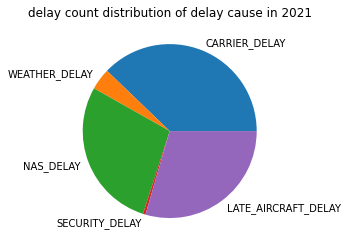

In [7]:
# count the number of delay times
df_count=(df_delay[config['Delay Cause']]>0).sum(0)
print(df_count)
# plot a pie chart contains the delay count of each cause
df_count.plot.pie(title='delay count distribution of delay cause in 2021',ylabel='')

## Carrier Delay Analysis

Carrier delay is the most influential factor for the delay, and it could be influenced by date and carriers. So I try to use these information predicting the carrier delay.

In [6]:
# extract the columns about carrier delay
df_delay_carrier=df_delay[["QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","MKT_UNIQUE_CARRIER","CARRIER_DELAY"]]
df_delay_carrier.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,CARRIER_DELAY
0,3,7,28,3,AA,0.000
1,2,6,1,2,WN,0.000
2,2,4,9,5,B6,0.000
3,1,1,1,5,WN,0.000
4,4,10,31,7,UA,0.000


The correlation between these columns are shown below, only quarter and month has a little correlation with carrier delay.

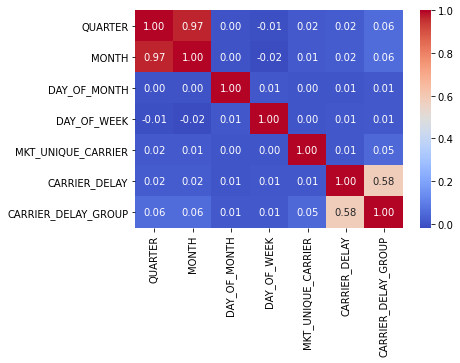

In [8]:
import seaborn as sns
"""
    Seaborn is a Python data visualization library based on matplotlib. 
    It provides a high-level interface for drawing attractive and informative statistical graphics.
    see more details on https://seaborn.pydata.org/
"""

# plot the correlation matrix of each column
sns.heatmap(df_delay_carrier.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
plt.show()

Then I cut the carrier delay time to serval groups, and add the carriers code to the variables. The new correlation matrix shown that month and carrier have a small influence to the carrier delay group, day of month and day of week make a little influence.

The correlation reflect the linear relationship between data, so the linear model could have a poor performance on this problem. We should consider nonlinear models like decision tree, kernel svm, neural network, etc.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,CARRIER_DELAY,CARRIER_DELAY_GROUP
0,3,7,28,3,0,0.000,0
1,2,6,1,2,9,0.000,0
2,2,4,9,5,2,0.000,0
3,1,1,1,5,9,0.000,0
4,4,10,31,7,8,0.000,0


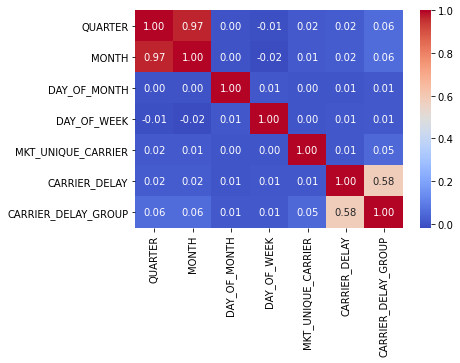

In [9]:
# divide the carrier delay time  into 5 groups
df_delay_carrier.loc[:,"CARRIER_DELAY_GROUP"]=pd.to_numeric(pd.cut(df_delay_carrier["CARRIER_DELAY"],[-math.inf,0,15,30,60,math.inf],labels=[0,1,2,3,4]))
# encode the carriers
df_delay_carrier.loc[:,"MKT_UNIQUE_CARRIER"]=pd.Categorical(df_delay_carrier["MKT_UNIQUE_CARRIER"]).codes
display(df_delay_carrier.head())

# plot the correlation matrix
sns.heatmap(df_delay_carrier.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
plt.show()

From the following box charts we could see that most of the delay time is less than 250 minutes. The distribution of delay time is correlated with these variables especially with carriers.

<AxesSubplot:title={'center':'CARRIER_DELAY'}, xlabel='MKT_UNIQUE_CARRIER'>

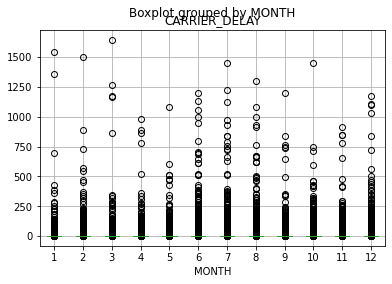

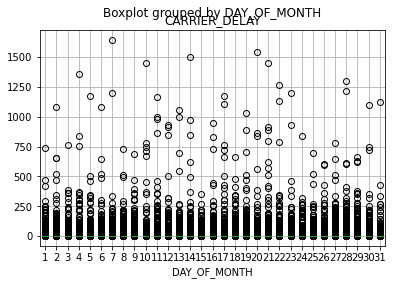

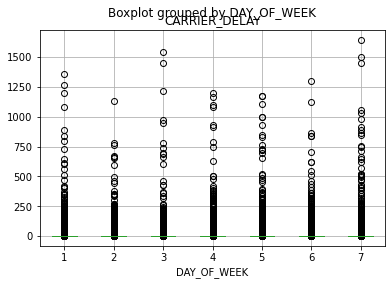

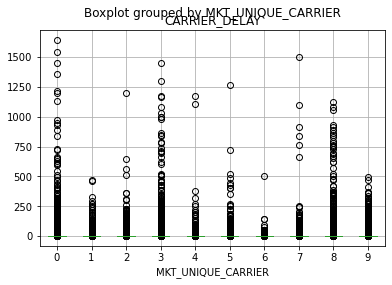

In [11]:
# plot the box chart by each variable
df_delay_carrier.boxplot("CARRIER_DELAY",by="MONTH")
df_delay_carrier.boxplot("CARRIER_DELAY",by="DAY_OF_MONTH")
df_delay_carrier.boxplot("CARRIER_DELAY",by="DAY_OF_WEEK")
df_delay_carrier.boxplot("CARRIER_DELAY",by="MKT_UNIQUE_CARRIER")

To use machine learning methods, we split the dataset into training set and test set. Here we first reorder the table randomly, then divide the data by indices.

In [10]:
from sklearn.utils import shuffle as reset
"""
    scikit-learn is a Machine Learning package in Python
    see more details on https://scikit-learn.org/stable/index.html
"""

def train_test_split(df,test_size=0.2,shuffle=True, random_state=None):
    """split the dataset into train set and test test

    Args:
        df (pd.DataFrame): the dataset
        test_size (float, optional): the precent size of test set. Defaults to 0.2.
        shuffle (bool, optional): whether reorder the dataset randomly before spliting. Defaults to True.
        random_state (_type_, optional): random seed. Defaults to None.

    Returns:
        train,test: train set and test set
    """
    if shuffle:
        df = reset(df, random_state=random_state)
	
    train = df[int(len(df)*test_size):].reset_index(drop = True)
    test  = df[:int(len(df)*test_size)].reset_index(drop = True)
    
    return train, test

In [11]:
train,test=train_test_split(df_delay_carrier)   # split train set and test set
carrier_feature_list=["DAY_OF_MONTH","DAY_OF_WEEK","MKT_UNIQUE_CARRIER"]    # input featuers

X_train,y_train=train[carrier_feature_list],train["CARRIER_DELAY_GROUP"]
X_test,y_test=test[carrier_feature_list],test["CARRIER_DELAY_GROUP"]


We also need a criteria to judge our models. Accuracy and confusion matrix could reflect the performance of the model. The accuracy contains 2 parts, accuracy rate and imbalanced accuracy rate. Accuracy rate is computed on the origin dataset and imbalanced accuracy rate is calculated on the dataset which eliminates zero samples.

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
"""
    Joblib is a set of tools to provide lightweight pipelining in Python. In particular:
        1. transparent disk-caching of functions and lazy re-evaluation (memoize pattern)
        2. easy simple parallel computing
    see more details on https://joblib.readthedocs.io/en/latest/
"""


def check_acc(model,X_test,y_test):
    """check the accuracy on the input

    Args:
        model (_type_): the model be checked
        X_test (_type_): input data
        y_test (_type_): true labels of the input data

    Returns:
        acc: the accuracy on the whole input
        imbalanced_acc: the accuracy on the samples excpet those with label 0
    """
    y_pre=model.predict(X_test)
    acc=((y_pre==y_test)).sum()/len(y_test)*100
    imbalanced_acc=((y_pre==y_test) & (y_test!=0)).sum()/(y_test!=0).sum()*100
    print(f"acc: {acc}  imbalanced acc: {imbalanced_acc}")
    return acc,imbalanced_acc

def plot_cm(model,X_test,y_test):
    """plot the confusion matrix 

    Args:
        model (_type_): the model be checked
        X_test (_type_): input data
        y_test (_type_): true labels of the input data
    """
    y_pred=model.predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


Then I choose some nonlinear machine learning algorithm (naive bayes, decision tree, and neural network) training on the dataset. The score of the model are high but the confusion matrix shows that these methods have a bad performance. Only ComplementNB model learning something because it is particularly suited for imbalanced data sets (see more details on https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)

[0.9010625 0.901     0.901     0.901     0.901    ]
acc: 90.08500000000001  imbalanced acc: 0.0


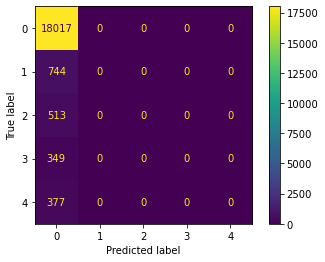

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# choose model
clf=GaussianNB()
# train model
clf.fit(X_train,y_train)

# cross validation
print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[0.4990625 0.5119375 0.4980625 0.507625  0.498625 ]
acc: 50.745  imbalanced acc: 19.027921406411583


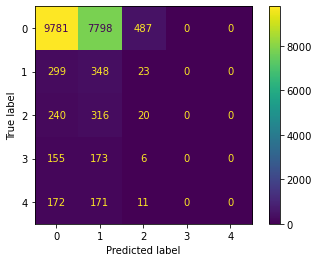

In [13]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score

# choose model
clf=ComplementNB(1)
# train model
clf.fit(X_train,y_train)

# cross validation
print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

[0.9010625 0.901     0.901     0.901     0.9009375]
acc: 90.08500000000001  imbalanced acc: 0.0


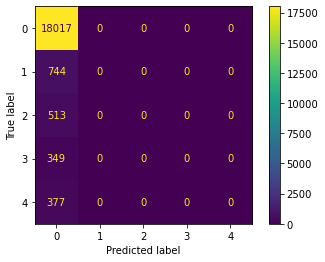

In [17]:
from sklearn import tree

# choose model
clf=tree.DecisionTreeClassifier(criterion="entropy",splitter="random",max_depth=8)
# train model
clf.fit(X_train,y_train)

# cross validation
print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

acc: 90.08500000000001  imbalanced acc: 0.0


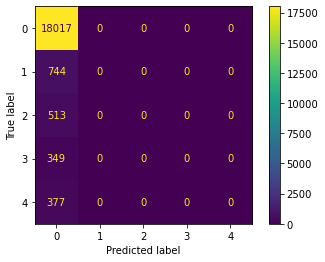

In [18]:
from sklearn.neural_network import MLPClassifier

# choose model
clf = MLPClassifier(solver='adam', batch_size=128,hidden_layer_sizes=(64, 64),)
# train model
clf.fit(X_train,y_train)

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

 The delay time is imbalanced in the dataset, over 85% of the delay time is 0. This would make a great trouble in machine learning. For example, a model could achieve over 85% accuracy only need to output 0 which means the network could not learn any useful features. Therefore, balance the dataset is necessary before training process. Over sampling and under sampling are common methods, which equalize dataset by increase the sparse samples or decrease the dense samples. Here we use over sampling to enhance the sparse samples. SMOTE and ADASYN are popular over sampling methods which generate new samples by neighbor interpolation. Here we choose ADASYN which could generate samples adaptively.

In [16]:
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN
"""
    Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying 
    on scikit-learn (imported as sklearn) and provides tools when dealing with classification 
    with imbalanced classes.
    see more details on https://imbalanced-learn.org/stable/
"""

# balance the train dataset
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
display(sorted(Counter(y_train).items()))


[(0, 71861), (1, 71861), (2, 71861), (3, 71861), (4, 71861)]

These models are trained on the balanced dataset, and their performances are following. 

[0.2345417  0.23383416 0.23606776 0.23520761 0.23784354]
acc: 38.765  imbalanced acc: 20.37317196167423


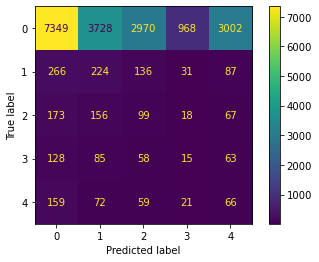

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

clf=GaussianNB()
clf.fit(X_train,y_train)
# save the model
joblib.dump(clf,"models/gaussian_bayes.pkl")

print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[0.21832383 0.21442544 0.21341269 0.21296874 0.21633995]
acc: 38.245000000000005  imbalanced acc: 18.204740292486132


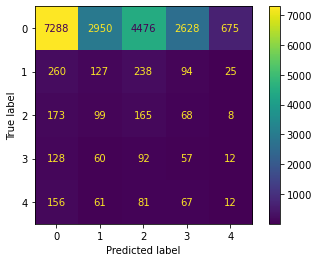

In [21]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score

clf=ComplementNB(1)
clf.fit(X_train,y_train)
joblib.dump(clf,"models/complement_bayes.pkl")

print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

[0.39121359 0.38170913 0.37614283 0.39171456 0.39474819]
acc: 26.415  imbalanced acc: 24.87073422957601


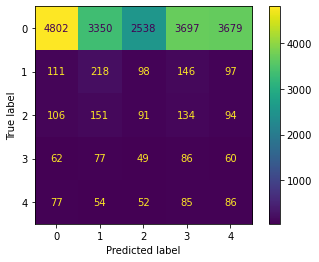

In [19]:
from sklearn import tree

clf=tree.DecisionTreeClassifier(criterion="entropy",splitter="random",max_depth=12)
clf.fit(X_train,y_train)
joblib.dump(clf,"models/tree.pkl")

print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_test,y_test)

[0.19874863 0.20267477 0.2014123  0.20794662 0.20590724]
acc: 7.4399999999999995  imbalanced acc: 17.95259707513868


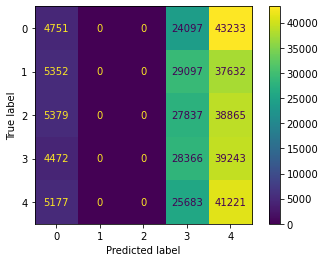

In [23]:
from sklearn.linear_model import SGDClassifier

clf=SGDClassifier()
clf.fit(X_train,y_train)
joblib.dump(clf,"models/sgd.pkl")

print(cross_val_score(clf,X_train,y_train,cv=5))

check_acc(clf,X_test,y_test)
plot_cm(clf,X_train,y_train)

We could find that these models perform better than training on the imbalanced dataset. However, the best accuracy is about 40%. The main error is that these models would identify samples with label 0 other labels. This problem could due to that balancing dataset makes the number of other samples large than the samples with label 0, which could result in the overfitting of these models

Therefore, we consider split these problem in two parts: predict whether carrier delay happen, how much the delay time is if there exists carrier delay. Then, we could generate train and test datasets for this two step, and the performance of these models is following.

In [21]:
# logistic regression dataset
df_delay_carrier_LR=df_delay_carrier.copy()
df_delay_carrier_LR.loc[:,"CARRIER_DELAY_GROUP"]=pd.to_numeric(pd.cut(df_delay_carrier["CARRIER_DELAY"],[-math.inf,0,math.inf],labels=[0,1]))

# spilt train and test dataset
train,test=train_test_split(df_delay_carrier_LR)
carrier_feature_list=["DAY_OF_MONTH","DAY_OF_WEEK","MKT_UNIQUE_CARRIER"]

X_train_LR,y_train_LR=train[carrier_feature_list],train["CARRIER_DELAY_GROUP"]
X_test_LR,y_test_LR=test[carrier_feature_list],test["CARRIER_DELAY_GROUP"]

# balance the train dataset
X_train_LR, y_train_LR = SMOTE().fit_resample(X_train_LR, y_train_LR)
display(sorted(Counter(y_train_LR).items()))

[(0, 71919), (1, 71919)]

[0.54303165 0.5405865  0.55089363 0.54284227 0.54377928]
acc: 59.63  imbalanced acc: 49.381443298969074


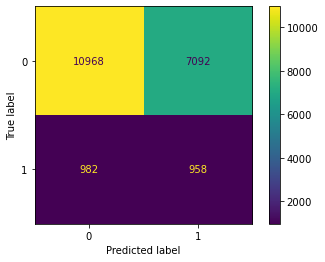

In [25]:
clf=GaussianNB()
clf.fit(X_train_LR,y_train_LR)

print(cross_val_score(clf,X_train_LR,y_train_LR,cv=5))
joblib.dump(clf,"models/gaussian_bayes_LR.pkl")

check_acc(clf,X_test_LR,y_test_LR)
plot_cm(clf,X_test_LR,y_test_LR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[0.52911577 0.53211869 0.53760194 0.533021   0.5322228 ]
acc: 54.38499999999999  imbalanced acc: 53.81443298969072


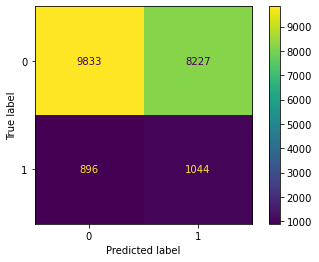

In [26]:
clf=ComplementNB(1)
clf.fit(X_train_LR,y_train_LR)

print(cross_val_score(clf,X_train_LR,y_train_LR,cv=5))
joblib.dump(clf,"models/complement_bayes_LR.pkl")

check_acc(clf,X_test_LR,y_test_LR)
plot_cm(clf,X_test_LR,y_test_LR)

[0.62725945 0.6397386  0.64224138 0.63861369 0.6397956 ]
acc: 59.155  imbalanced acc: 55.773092369477915


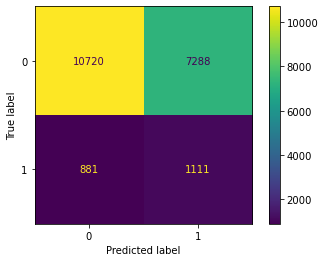

In [22]:
clf=tree.DecisionTreeClassifier(criterion="entropy",splitter="random",max_depth=15)
clf.fit(X_train_LR,y_train_LR)
joblib.dump(clf,"models/tree_LR.pkl")

print(cross_val_score(clf,X_train_LR,y_train_LR,cv=5))

check_acc(clf,X_test_LR,y_test_LR)
plot_cm(clf,X_test_LR,y_test_LR)

[0.50086757 0.50001735 0.51258025 0.50747874 0.51330904]
acc: 55.86  imbalanced acc: 52.52577319587629


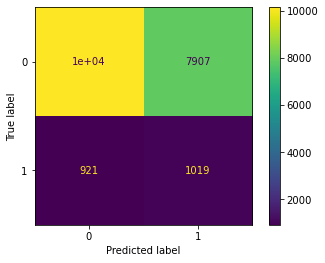

In [28]:
clf=SGDClassifier()
clf.fit(X_train_LR,y_train_LR)
joblib.dump(clf,"models/sgd_LR.pkl")

print(cross_val_score(clf,X_train_LR,y_train_LR,cv=5))

check_acc(clf,X_test_LR,y_test_LR)
plot_cm(clf,X_test_LR,y_test_LR)

acc: 68.91000000000001  imbalanced acc: 41.907216494845365


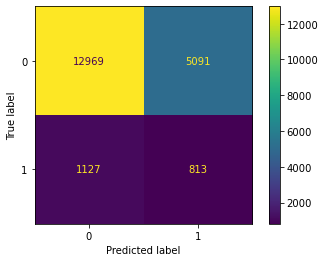

In [29]:
clf = MLPClassifier(solver='adam', batch_size=128,hidden_layer_sizes=(64, 64),)
clf.fit(X_train_LR,y_train_LR)
joblib.dump(clf,'models/mlp_LR.pkl')

check_acc(clf,X_test_LR,y_test_LR)
plot_cm(clf,X_test_LR,y_test_LR)

The most accuracy on the first step is about 60% by the decision tree model

Then we extract the samples except with label 0 from the origin dataset to train the second step models. This dataset is balanced so it could train the model directly.

In [23]:
# extract classification dataset
df_delay_carrier_cl=df_delay_carrier[df_delay_carrier["CARRIER_DELAY_GROUP"]>0]

# split dataset
train,test=train_test_split(df_delay_carrier_cl,test_size=0.1)
carrier_feature_list=["DAY_OF_MONTH","DAY_OF_WEEK","MKT_UNIQUE_CARRIER"]

X_train_cl,y_train_cl=train[carrier_feature_list],train["CARRIER_DELAY_GROUP"]
X_test_cl,y_test_cl=test[carrier_feature_list],test["CARRIER_DELAY_GROUP"]
display(sorted(Counter(y_train_cl).items()))


[(1, 3234), (2, 2539), (3, 1610), (4, 1683)]

[0.37016265 0.37016265 0.37037037 0.3698092  0.37037037]
acc: 37.27272727272727  imbalanced acc: 37.27272727272727


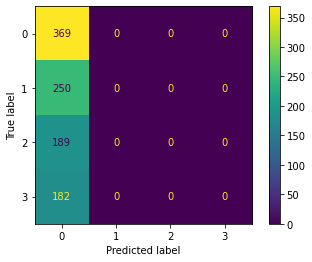

In [31]:
clf=GaussianNB()
clf.fit(X_train_cl,y_train_cl)

print(cross_val_score(clf,X_train_cl,y_train_cl,cv=5))
joblib.dump(clf,"models/gaussian_bayes_cl.pkl")

check_acc(clf,X_test_cl,y_test_cl)
plot_cm(clf,X_test_cl,y_test_cl)

[0.29108245 0.24060572 0.27441077 0.2312009  0.2654321 ]
acc: 28.18181818181818  imbalanced acc: 28.18181818181818


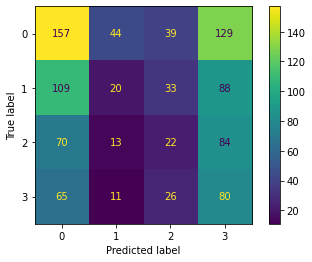

In [32]:
clf=ComplementNB()
clf.fit(X_train_cl,y_train_cl)

print(cross_val_score(clf,X_train_cl,y_train_cl,cv=5))
joblib.dump(clf,"models/complement_bayes_cl.pkl")

check_acc(clf,X_test_cl,y_test_cl)
plot_cm(clf,X_test_cl,y_test_cl)

[0.37045204 0.36900165 0.37286266 0.38223938 0.37948152]
acc: 39.026812313803376  imbalanced acc: 39.026812313803376


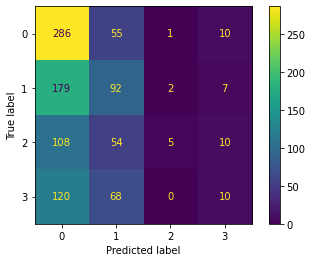

In [39]:
clf=tree.DecisionTreeClassifier(criterion="entropy",splitter="random",max_depth=7)
clf.fit(X_train_cl,y_train_cl)
joblib.dump(clf,"models/tree_cl.pkl")

print(cross_val_score(clf,X_train_cl,y_train_cl,cv=5))

check_acc(clf,X_test_cl,y_test_cl)
plot_cm(clf,X_test_cl,y_test_cl)

[0.23443634 0.27257431 0.28619529 0.32098765 0.19023569]
acc: 31.515151515151512  imbalanced acc: 31.515151515151512


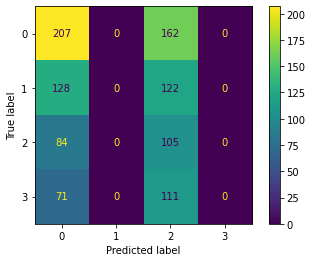

In [34]:
clf=SGDClassifier(random_state=2)
clf.fit(X_train_cl,y_train_cl)
joblib.dump(clf,"models/sgd_cl.pkl")

print(cross_val_score(clf,X_train_cl,y_train_cl,cv=5))

check_acc(clf,X_test_cl,y_test_cl)
plot_cm(clf,X_test_cl,y_test_cl)

acc: 36.666666666666664  imbalanced acc: 36.666666666666664


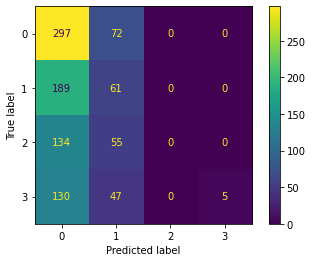

In [35]:
clf = MLPClassifier(solver='sgd', batch_size=64,hidden_layer_sizes=(32,32,),)
clf.fit(X_train_cl,y_train_cl)
joblib.dump(clf,'models/mlp_cl.pkl')

check_acc(clf,X_test_cl,y_test_cl)
plot_cm(clf,X_test_cl,y_test_cl)

The most accuracy on the classification is about 40% by the decision tree model. And the tree model have a good performance on class 1 ((0,15]) and class 2 ((15,60]). Finally, we could combine the best model in the two steps to make the prediction.

In [41]:
def predict_carrier_delay(input):
    """predict the carrier delay based on month, day of month, day of week, carrier

    Args:
        input (_type_): a vector input month, day of month, day of week, carrier

    Returns:
        delay_time: an interger describing the group of delay time
    """
    model_first=joblib.load("models/tree_LR.pkl")
    model_second=joblib.load("models/tree_cl.pkl")
    is_delay=model_first.predict([input])
    if is_delay==0:
        return is_delay
    delay_time=model_second.predict([input])
    return delay_time
predict_carrier_delay(X_test.loc[0])

array([0], dtype=int64)

## Weather Delay Analysis

Weather delay time is correlated with the weather in the origin city and destination city of the flight. Here we collected the weather data of all the cities in the flight table (see more details in `data_collection.ipynb`). This part I trained a neural network to predict the weather delay due to the weather information is a long vector and the number of data is serval millions

Fetch flight data from flight table in the database

In [42]:
sql='''SELECT 
        MONTH,
        DAY_OF_MONTH,
        ORIGIN_CITY_NAME,
        DEST_CITY_NAME,
        AIR_TIME,
        DISTANCE,
        ARR_DELAY,
        ARR_DELAY_NEW,
        CARRIER_DELAY,
        WEATHER_DELAY,
        NAS_DELAY,
        SECURITY_DELAY,
        LATE_AIRCRAFT_DELAY FROM flight
        ORDER BY RANDOM()
        LIMIT 100000;'''
        
df_delay=pd.read_sql(sql,db)

# NaN in this table means 0, replace NaN by 0
df_delay=df_delay.fillna(0)
df_delay.head()

,MONTH,DAY_OF_MONTH,ORIGIN_CITY_NAME,DEST_CITY_NAME,AIR_TIME,DISTANCE,ARR_DELAY,ARR_DELAY_NEW,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,5,22,"Grand Rapids, MI","Minneapolis, MN",63.000,408.000,-25.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2,20,"Evansville, IN","Charlotte, NC",66.000,414.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000
2,5,6,"Portland, OR","San Diego, CA",138.000,933.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,6,17,"Dallas, TX","Long Beach, CA",158.000,1232.000,7.000,7.000,0.000,0.000,0.000,0.000,0.000
4,12,23,"Chicago, IL","Jackson, WY",211.000,1162.000,366.000,366.000,244.000,0.000,39.000,0.000,83.000


Fetch weather data of all the cities from weather table in the database and normalization these data. Normalization on input is essential for neural network because if the number in the input vector is big, the parameters of the network could be very small, the computer float error would influence the performance of neural network.

In [40]:
sql='''SELECT 
        city_name,
        month,
        day,
        temp_min,
        temp_max,
        temp_mean,
        pressure_min,
        pressure_max,
        pressure_mean,
        humidity_min,
        humidity_max,
        humidity_mean,
        wind_min,
        wind_max,
        wind_mean,
        precipitation_min,
        precipitation_max,
        precipitation_mean,
        clouds_min,
        clouds_max,
        clouds_mean FROM weather;'''
        
# fetch data from sql database
df_weather=pd.read_sql(sql,db)
display(df_weather.head())
# normalization
for feature in config["Weather Features"]:
        df_weather[feature]=pd.to_numeric(df_weather[feature])
        df_weather[feature]=(df_weather[feature]-df_weather[feature].mean())/df_weather[feature].std()
# replace nan to 0
df_weather=df_weather.fillna(0)
df_weather.head()

,city_name,month,day,temp_min,temp_max,temp_mean,pressure_min,pressure_max,pressure_mean,humidity_min,humidity_max,humidity_mean,wind_min,wind_max,wind_mean,precipitation_min,precipitation_max,precipitation_mean,clouds_min,clouds_max,clouds_mean
0,"San Jose, CA",1,1,276,286.680,280.690,1012,1028,1020.260,23,100,68.590,0,10.300,2.140,0,0.300,0,0,90,23.200
1,"San Jose, CA",1,2,277.43,287.370,281.300,995,1029,1021.060,21,100,71.180,0,8.700,1.750,0,0.900,0.03,0,100,32.670
2,"San Jose, CA",1,3,277.98,287.330,281.730,1004,1026,1019.850,16,100,74.400,0,12.900,1.930,0,3.000,0.06,0,92,33.290
3,"San Jose, CA",1,4,279.73,287.850,282.850,1006,1031,1019.400,35,100,79.360,0,14.400,2.340,0,3.000,0.19,0,100,50.490
4,"San Jose, CA",1,5,279.11,288.110,282.850,1002,1036,1020.420,26,100,78.270,0,11.300,2.290,0,3.000,0.15,0,91,41.690


,city_name,month,day,temp_min,temp_max,temp_mean,pressure_min,pressure_max,pressure_mean,humidity_min,humidity_max,humidity_mean,wind_min,wind_max,wind_mean,precipitation_min,precipitation_max,precipitation_mean,clouds_min,clouds_max,clouds_mean
0,"San Jose, CA",1,1,-0.639,-0.561,-0.609,0.450,-0.083,1.027,-0.273,0.286,0.034,-0.514,-0.056,-1.352,0.000,-0.780,-0.913,-0.161,-0.927,-1.122
1,"San Jose, CA",1,2,-0.492,-0.494,-0.548,0.249,0.046,1.178,-0.431,0.286,0.254,-0.514,-0.164,-1.771,0.000,-0.567,-0.618,-0.161,0.949,-0.484
2,"San Jose, CA",1,3,-0.435,-0.498,-0.505,0.355,-0.340,0.949,-0.825,0.286,0.528,-0.514,0.121,-1.577,0.000,0.177,-0.323,-0.161,-0.552,-0.442
3,"San Jose, CA",1,4,-0.255,-0.447,-0.393,0.379,0.304,0.863,0.673,0.286,0.951,-0.514,0.223,-1.137,0.000,0.177,0.956,-0.161,0.949,0.717
4,"San Jose, CA",1,5,-0.319,-0.422,-0.393,0.332,0.949,1.057,-0.037,0.286,0.858,-0.514,0.012,-1.191,0.000,0.177,0.563,-0.161,-0.740,0.124


Here we use `pytorch` to construct our neural network. The input is a vector that contains the weather information of origin city and destination city, and the output is a probability vector on delay time group. Hence the neural network need linear layers and active functions

In [44]:
import torch
"""
  pytorch is n open source machine learning framework that accelerates 
  the path from research prototyping to production deployment.
  see more details on https://pytorch.org/
"""
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy import stats
"""
  scipy provides Fundamental algorithms for scientific computing in Python
  see more details on https://scipy.org/
"""

class SonnetLinear(nn.Module):
  """A Sonnet linear module.

  Always includes biases and only supports ReLU activations.
  """

  def __init__(self, in_size:int, out_size:int, activate_relu:bool=True):
    """Creates a Sonnet linear layer.

    Args:
      in_size: (int) number of inputs
      out_size: (int) number of outputs
      activate_relu: (bool) whether to include a ReLU activation layer
    """
    super(SonnetLinear, self).__init__()
    self._activate_relu = activate_relu
    std = 1.0 / math.sqrt(in_size)
    mean = 0
    lower = (-2 * std - mean) / std
    upper = (2 * std - mean) / std
    self._weight = nn.Parameter(
        torch.Tensor(
            stats.truncnorm.rvs(
                lower, upper, loc=mean, scale=std, size=[out_size,
                                                            in_size])))
    self._bias = nn.Parameter(torch.zeros([out_size]))

  def forward(self, tensor:torch.Tensor):
    y = F.linear(tensor, self._weight, self._bias)
    return F.relu(y) if self._activate_relu else y


class MLP(nn.Module):
  """A simple network built from nn.linear layers."""

  def __init__(self,
               input_size:int,
               hidden_sizes:list,
               output_size:int,
               activate_final:bool=False):
    """Create the MLP.

    Args:
      input_size: (int) number of inputs
      hidden_sizes: (list) sizes (number of units) of each hidden layer
      output_size: (int) number of outputs
      activate_final: (bool) should final layer should include a ReLU
    """

    super(MLP, self).__init__()
    if isinstance(hidden_sizes,int):
      hidden_sizes=[hidden_sizes]
    self._layers = []
    # Hidden layers
    for size in hidden_sizes:
      self._layers.append(SonnetLinear(in_size=input_size, out_size=size))
      input_size = size
    # Output layer
    self._layers.append(
        SonnetLinear(
            in_size=input_size,
            out_size=output_size,
            activate_relu=activate_final))

    self.model = nn.ModuleList(self._layers)

  def forward(self, x:torch.Tensor):
    for layer in self.model:
      x = layer(x)
    return x

net=MLP(1,2,3)
net(torch.Tensor(1))

tensor([-1.4013e-45,  0.0000e+00, -1.4013e-45], grad_fn=<AddBackward0>)

Create the dataset and dump them to local files, which could save a lot of time when training next time.

In [45]:
import numpy as np
import os
import tqdm

X_path='dataset/X.npy'
y_path='dataset/y.npy'

def get_weather_info(month,day,city_name):
    """get weather information of the city at the given day

    Args:
        month (number): month
        day (number): day
        city_name (str): city name

    Returns:
        numpy.array: an array contains all the weather information
    """
    df_weather_selected=df_weather[(df_weather["city_name"]==city_name)&(df_weather["day"]==day)&(df_weather["month"]==month)]
    
    return df_weather_selected[config["Weather Features"]].to_numpy(dtype=np.float32)

def gen_dataset(df_weather_delay):
    """_summary_

    Args:
        df_weather_delay (_type_): _description_

    Returns:
        _type_: _description_
    """

    X,y=[],[]
    for index,row in tqdm.tqdm(df_weather_delay.iterrows(),total=config['Sample Size']):
        month=row["MONTH"]
        day=row["DAY_OF_MONTH"]
        origin_city=row["ORIGIN_CITY_NAME"]
        dest_city=row["DEST_CITY_NAME"]
        origin_weather_info=get_weather_info(month,day,origin_city)
        if origin_weather_info.size==0:
            continue
        dest_weather_info=get_weather_info(month,day,dest_city)
        if dest_weather_info.size==0:
            continue
        X.append(np.hstack([origin_weather_info[0],dest_weather_info[0]]))
        y.append(row['WEATHER_DELAY'])
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

df_weather_delay=df_delay[["MONTH","DAY_OF_MONTH","ORIGIN_CITY_NAME","DEST_CITY_NAME","WEATHER_DELAY"]]
df_weather_delay["WEATHER_DELAY"]=pd.cut(df_weather_delay["WEATHER_DELAY"],[-math.inf,0,15,30,60,math.inf],labels=[0,1,2,3,4])
print(len(df_weather_delay))

if os.path.exists(X_path) and os.path.exists(y_path):
    X=np.load(X_path)
    y=np.load(y_path)
else:
    X,y=gen_dataset(df_weather_delay)
    np.save(X_path,X)
    np.save(y_path,y)


<ipython-input-45-0ea3372f931b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_delay["WEATHER_DELAY"]=pd.cut(df_weather_delay["WEATHER_DELAY"],[-math.inf,0,15,30,60,math.inf],labels=[0,1,2,3,4])
  0%|          | 6/100000 [00:00<30:00, 55.54it/s]

100000


100%|██████████| 100000/100000 [25:49<00:00, 64.54it/s]


(99375, 36) (99375,)


Split dataset into train set, val set, and test set.

In [46]:
from sklearn.model_selection import train_test_split

def dataset_split(X,y,split=[6,1,1]):
    ratios = np.array(split) / np.sum(split)
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=ratios[0])
    
    ratios = np.array(split[1:]) / np.sum(split[1:])
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=ratios[0])
    return X_train,X_val,X_test,y_train,y_val,y_test

X_train,X_val,X_test,y_train,y_val,y_test=dataset_split(X,y)

Balance the train dataset

In [47]:
display(X.shape,y.shape)
display(sorted(Counter(y_train).items()))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# X_val, y_val = ADASYN().fit_resample(X_val, y_val)
display(sorted(Counter(y_train).items()))

(99375, 36)

(99375,)

[(0, 73691), (1, 175), (2, 205), (3, 191), (4, 269)]

[(0, 73691), (1, 73691), (2, 73691), (3, 73691), (4, 73691)]

Train the neural network

In [48]:
from torch.utils.data import sampler, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
in_size=X.shape[1]
out_size=5
hidden_sizes=[128,64,32]
learn_rate=0.001
batch_size=128

net=MLP(in_size,hidden_sizes,out_size)
optimizer=torch.optim.Adam(net.parameters(),learn_rate,weight_decay=1e-5)
loss_func=F.cross_entropy

train_dataset=TensorDataset(torch.FloatTensor(X_train),torch.LongTensor(y_train))
val_dataset=TensorDataset(torch.FloatTensor(X_val),torch.LongTensor(y_val))
test_dataset=TensorDataset(torch.FloatTensor(X_test),torch.LongTensor(y_test))

loader_train = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,)

loader_val = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

loader_test = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

def check_acc(net,loader):
    acc_total=0
    count=0
    net.eval()
    with torch.no_grad():
        for X,y in loader:
            y_pred=net(X).max(-1)[1]
            acc=(y_pred==y).sum()/len(y)
            acc_total+=acc
            count+=1
        acc_total=acc_total/count
    return acc_total.item()

def plot_cm(net,X,y):
    y_pred=net(torch.FloatTensor(X)).max(-1)[1]
    y_true=y
    cm=confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

def train(net,epoch=100):
    loss_record=[]
    acc_record=[]
    for e in tqdm.tqdm(range(epoch)):
        net.train()
        for x,target in loader_train:
            optimizer.zero_grad()
            predict=net(x)
            loss=loss_func(predict,target)
            loss.backward()
            optimizer.step()
            loss_record.append(loss.item())
        acc=check_acc(net,loader_val)
        acc_record.append(acc)
    return loss_record,acc_record

loss_record,acc_record=train(net)


100%|██████████| 100/100 [09:48<00:00,  5.88s/it]


Show the record of loss and accuracy on the validation set.

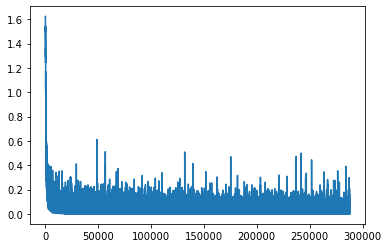

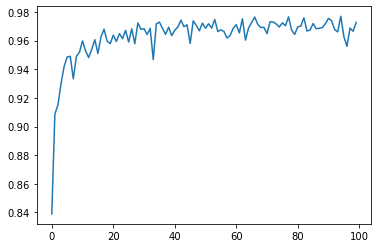

In [49]:
plt.plot(loss_record)
plt.show()
plt.plot(acc_record)
plt.show()

Plot the confusion matrix on the train dataset and the accuracy on the test dataset

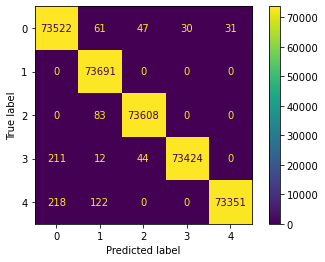

the accuracy on test dataset is: 97.28156924247742%


In [50]:
X_test_balanced,y_test_balanced=SMOTE().fit_resample(X_test, y_test)
plot_cm(net,X_train,y_train)
acc_test=check_acc(net,loader_test)
print(f"the accuracy on test dataset is: {acc_test*100}%")